# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)
- homework_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

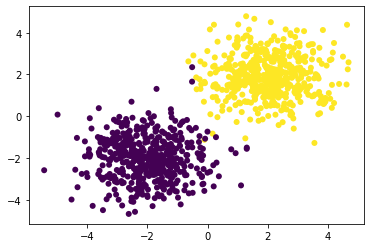

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

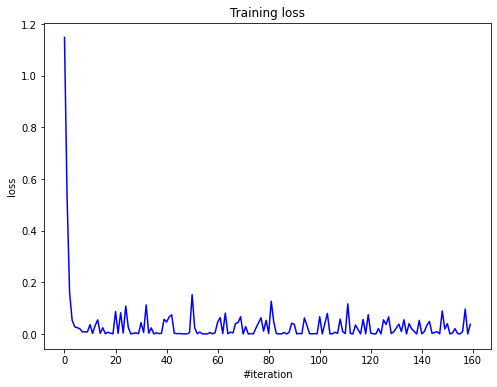

Current loss: 0.037698


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [9]:
def to_onehot(labels):
    res = np.zeros((len(labels), 10))
    for i, lbl in enumerate(labels):
        res[i][lbl] = 1
    return res

y_train = to_onehot(y_train)
#y_val = to_onehot(y_val)
y_test = to_onehot(y_test)


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [10]:
def make_net(activation, use_bn=False):
    net = Sequential()
    net.add(Linear(28 * 28, 128))
    if use_bn:
        net.add(BatchNormalization(alpha=0.9))
        net.add(ChannelwiseScaling(128))
    net.add(activation)
    net.add(Linear(128, 10))
    net.add(LogSoftMax())
    return net

nn = make_net(ReLU())
nn.forward(np.zeros((1, 28 * 28)))



array([[-2.22435494, -2.34085658, -2.28582695, -2.21640934, -2.37741059,
        -2.3856848 , -2.32993644, -2.26416631, -2.29472073, -2.3217334 ]])

In [11]:
from tqdm import trange

def do_train(net, n_epoch, opt_config, opt, batch_size=128):
    criterion = ClassNLLCriterion()
    train_losses = []
    test_losses = []
    opt_state = {}

    for i in trange(n_epoch):
        for (xtrain, ytrain), (xtest, ytest) in zip(
                get_batches((X_train, y_train), batch_size), 
                get_batches((X_test, y_test), batch_size)
        ):
            xtrain = xtrain.reshape(-1, 28 * 28)
            net.zeroGradParameters()
            net.train()

            # Forward
            predictions = net.forward(xtrain)
            loss = criterion.forward(predictions, ytrain)

            # Backward
            dp = criterion.backward(predictions, ytrain)
            net.backward(xtrain, dp)

            # Update weights
            opt(net.getParameters(), 
                net.getGradParameters(), 
                opt_config,
                opt_state)      

            train_losses.append(loss)
            
            # eval
            net.evaluate()
            test_losses.append(
                criterion.forward(net.forward(xtest.reshape(-1, 28 * 28)), ytest)
            )
            net.zeroGradParameters()

    return train_losses, test_losses

In [12]:
def ema(data, coeff=0.95):
    result = [data[0]]
    for value in data[1:]:
        result.append(result[-1] * coeff + value * (1 - coeff))
        prev = result[-1]
    return result

100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


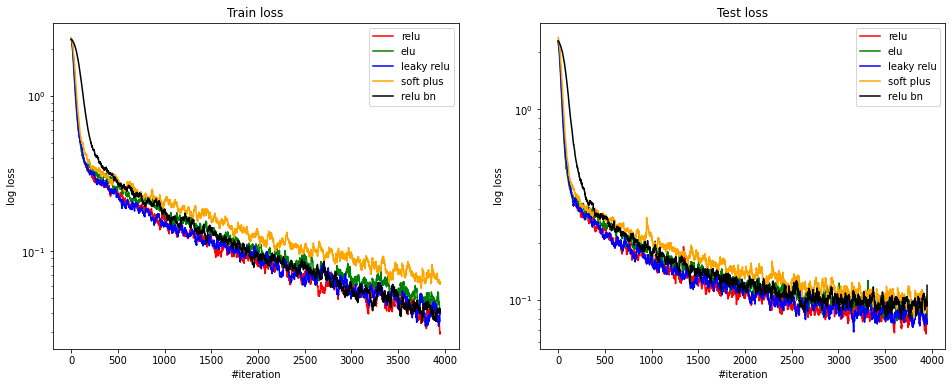

In [13]:
%matplotlib inline

N_EPOCH = 50

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

ax1.set_title("Train loss")
ax1.set_xlabel("#iteration")
ax1.set_ylabel("log loss")
ax1.set_yscale('log')

ax2.set_title("Test loss")
ax2.set_xlabel("#iteration")
ax2.set_ylabel("log loss")
ax2.set_yscale('log')

opt_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
opt = adam_optimizer

relu_net = make_net(ReLU())
train_losses, test_losses = do_train(relu_net, N_EPOCH, opt_config, opt)
ax1.plot(ema(train_losses), 'red', label='relu')
ax2.plot(ema(test_losses), 'red', label='relu')

elu_net = make_net(ELU())
train_losses, test_losses = do_train(elu_net, N_EPOCH, opt_config, opt)
ax1.plot(ema(train_losses), 'green', label='elu')
ax2.plot(ema(test_losses), 'green', label='elu')

leaky_relu_net = make_net(LeakyReLU())
train_losses, test_losses = do_train(leaky_relu_net, N_EPOCH, opt_config, opt)
ax1.plot(ema(train_losses), 'blue', label='leaky relu')
ax2.plot(ema(test_losses), 'blue', label='leaky relu')

soft_plus_net = make_net(SoftPlus())
train_losses, test_losses = do_train(soft_plus_net, N_EPOCH, opt_config, opt)
ax1.plot(ema(train_losses), 'orange', label='soft plus')
ax2.plot(ema(test_losses), 'orange', label='soft plus')

relu_bn_net = make_net(ReLU(), use_bn=True)
train_losses, test_losses = do_train(relu_bn_net, N_EPOCH, opt_config, opt)
ax1.plot(ema(train_losses), 'black', label='relu bn')
ax2.plot(ema(test_losses), 'black', label='relu bn')


ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
plt.show()   
    

100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


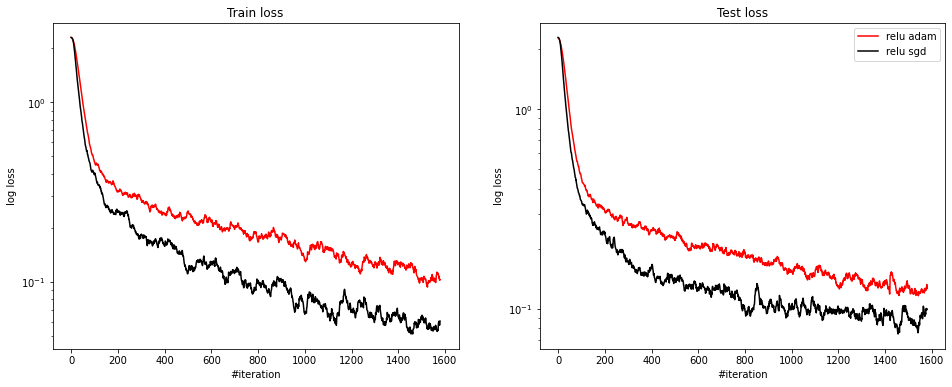

In [14]:
%matplotlib inline

N_EPOCH = 20

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

ax1.set_title("Train loss")
ax1.set_xlabel("#iteration")
ax1.set_ylabel("log loss")
ax1.set_yscale('log')

ax2.set_title("Test loss")
ax2.set_xlabel("#iteration")
ax2.set_ylabel("log loss")
ax2.set_yscale('log')

adam_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
adam_net = make_net(ReLU())
train_losses, test_losses = do_train(adam_net, N_EPOCH, adam_config, adam_optimizer)
ax1.plot(ema(train_losses), 'red', label='relu adam')
ax2.plot(ema(test_losses), 'red', label='relu adam')

sgd_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
sgd_net = make_net(ReLU())
train_losses, test_losses = do_train(sgd_net, N_EPOCH, sgd_config, sgd_momentum)
ax1.plot(ema(train_losses), 'black', label='relu sgd')
ax2.plot(ema(test_losses), 'black', label='relu sgd')


# Visualize

plt.legend(loc='upper right')
plt.show()   
    

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

# Your answer goes here. ################################################
SoftPlus работает несколько хуже чем ReLU, ELU, Leaky ReLU.
BatchNormalization не помогает
sgd_momentum на MNIST работает лучше чем adam 

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [15]:
# Your code goes here. ################################################

Print here your accuracy on test set. It should be around 90%.

In [16]:
from sklearn.metrics import accuracy_score

probas = relu_net.forward(X_val.reshape(-1, 28 * 28))
y_pred = np.argmax(probas, axis=1)
print('relu', accuracy_score(y_val, y_pred))

probas = elu_net.forward(X_val.reshape(-1, 28 * 28))
y_pred = np.argmax(probas, axis=1)
print('elu', accuracy_score(y_val, y_pred))

probas = leaky_relu_net.forward(X_val.reshape(-1, 28 * 28))
y_pred = np.argmax(probas, axis=1)
print('leaky_relu_net', accuracy_score(y_val, y_pred))

probas = soft_plus_net.forward(X_val.reshape(-1, 28 * 28))
y_pred = np.argmax(probas, axis=1)
print('soft_plus_net', accuracy_score(y_val, y_pred))

relu_bn_net.evaluate()
probas = relu_bn_net.forward(X_val.reshape(-1, 28 * 28))
y_pred = np.argmax(probas, axis=1)
print('relu_bn_net', accuracy_score(y_val, y_pred))

probas = sgd_net.forward(X_val.reshape(-1, 28 * 28))
y_pred = np.argmax(probas, axis=1)
print('relu_sgd', accuracy_score(y_val, y_pred))

relu 0.9731
elu 0.9751
leaky_relu_net 0.9741
soft_plus_net 0.9716
relu_bn_net 0.974
relu_sgd 0.9732
